# Apply HUX Mapping Technique to in-situ Helios1 spacecraft observations

In [1]:
import matplotlib.pyplot as plt
from scipy import stats
from scipy import interpolate
import numpy as np
import scipy
import copy
import pickle
import math
import os
import datetime as dt 

from heliopy.data import helios
from heliopy.data import omni
import heliopy.data.spice as spicedata
import heliopy.spice as spice
from astropy.coordinates import SkyCoord
import astropy.units as u
from heliopy.data.solo import download

from tools.MASweb import get_mas_path
from psipy.model import MASOutput
from psipy.data import sample_data
from psipy.model.variable import Variable

from code.archimedes_sprial import cmap_spiral, compute_phi_shift_forward
from code.hux_propagation import *
from code.carrington_dates import * 

# matplotlib fontsize
%matplotlib notebook
%matplotlib inline
fs1=12
plt.rcParams['savefig.facecolor'] = 'white'

# Read in global MHD model (MAS) solutions 

#### Helios 1 time inetrvals: CR1634, CR1647, CR1653, CR1674, CR1681, CR1710, CR1716, CR1723, CR1730, CR1736.

Download MAS solutions from [Predictive Science Inc. website](http://www.predsci.com/data/runs).

For more information about reading MHD solutions see [PsiPy documentation website](https://psipy.readthedocs.io/en/stable/guide/getting_started.html#getting-data).

In [2]:
# set up the time interval and carrington rotation. 
case_study = "cr1653"
starttime, endtime, cr = get_time_interval(case_study)

In [3]:
print("start time = ", starttime)
print("end time = ", endtime)
print("Carrington Rotation", cr)

start time =  1977-03-23 00:00:00
end time =  1977-04-20 00:00:00
Carrington Rotation 1653


In [4]:
# create directory to save figures
try:
    os.mkdir("figures/helios1/" + case_study + "/")
except OSError as error:
    print(error)

[WinError 183] Cannot create a file when that file already exists: 'figures/helios1/cr1653/'


In [5]:
# mas output - br, rho, vr
# 1647,1723 wso_mas_mas_std_0101
# 1654, 1655, 1660 kpo_mas_mas_std_0101

mas_path = get_mas_path(cr=cr, folder="kpo_mas_mas_std_0101")

print(mas_path)
model = MASOutput(mas_path)

print(model.variables)

C:\Users\Opali\data\mas_helio\cr1653
['br', 'rho', 'vr']


In [6]:
# read in MHD velocity results. 
vr_model = model['vr']

In [7]:
# save MHD mesh coordinates Heliographic (rotating) Coordinate System (HG)
# phi - (0, 2pi)
p = vr_model.phi_coords
# sin(theta) - (-pi/2, pi/2)
t = vr_model.theta_coords
# 30 solar radii to approximately 1 AU
r = vr_model.r_coords
# velocity profile 
f = vr_model.data

In [8]:
print("Velocity matrix shape: ", np.shape(f))
print("Phi dim: ", np.shape(f)[0])
print("Theta dim: ", np.shape(f)[1])
print("Radial dim: ", np.shape(f)[2])
print("Velocity matrix dtype: ", f.dtype)


Velocity matrix shape:  (128, 111, 140)
Phi dim:  128
Theta dim:  111
Radial dim:  140
Velocity matrix dtype:  float32


In [9]:
# force periodicity on f
# since the last phi index is less than 2*pi, then we will append 2*pi to phi scale.
p_plot = np.append(p, 2*np.pi) 

# Phi: from radians to degrees. longitude.
p_plot = (180/np.pi)*p_plot

In [10]:
# append the first slice p=0 to velocity matrix. 
f_plot = np.append(f,[f[0,:, :]],axis=0)

In [11]:
# Radius: from solar radii to km. 
# 1 solar radii = 695,700 km
r_plot = (695700)*r

In [12]:
# convert to sin(Lat.) [-1, 1]
t_plot = np.sin(t)

In [13]:
# NOTE: pcolorfast and pcolormesh want the coords of pixel corners not centers --> build a "half mesh" for p & t.
# - This means making an array that is n+1 size and has the midpoint positions of the original.
# - Here we clip the endpoints of the half mesh to the original bounds, vs extrapolate.
# - see also https://matplotlib.org/api/_as_gen/matplotlib.pyplot.pcolormesh.html.

cmap = 'gnuplot'

ph = np.concatenate([[p_plot[0]], 0.5 * (p_plot[1:] + p_plot[:-1]), [p_plot[-1]]])
th = np.concatenate([[t_plot[0]], 0.5 * (t_plot[1:] + t_plot[:-1]), [t_plot[-1]]])

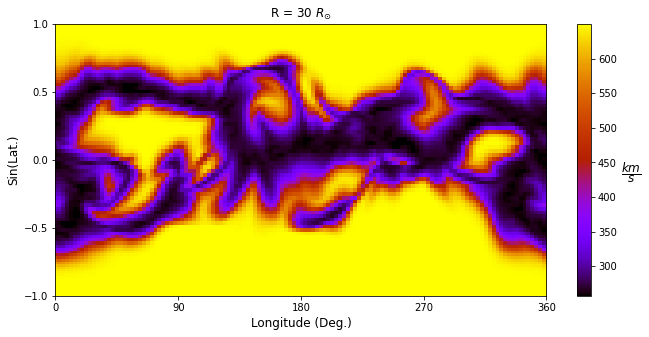

In [14]:
fig, ax = plt.subplots(figsize = (11,5))
ax.set_ylim(-1, 1)
ax.set_xlim(0, 360)
ax.set_title("R = 30 $R_{\odot}$", fontsize=fs1)
ax.set_ylabel("Sin(Lat.)", fontsize=fs1)
ax.set_xlabel("Longitude (Deg.)", fontsize=fs1)
ax.set_yticks(ticks=[-1, -0.5, 0, 0.5, 1])
ax.set_xticks(ticks=[0, 90, 180, 270, 360])
_ = im = ax.pcolorfast(ph, th, f_plot[:, :, 0].T, cmap=cmap)
cb = fig.colorbar(im, ax=ax)
cb.set_label('$\dfrac{km}{s}$', fontsize=fs1, rotation=360, labelpad=15)
#plt.savefig('figures/helios1/' + case_study + '/vr_30rs_map.png')

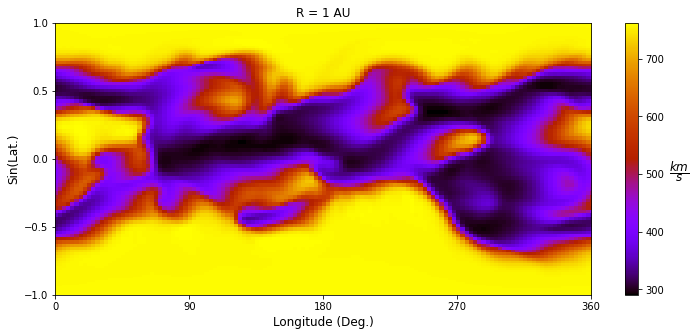

In [15]:
fig, ax = plt.subplots(figsize = (12,5))
ax.set_ylim(-1, 1)
ax.set_xlim(0, 360)
ax.set_title("R = 1 AU", fontsize=fs1)
ax.set_ylabel("Sin(Lat.)", fontsize=fs1)
ax.set_xlabel("Longitude (Deg.)", fontsize=fs1)
ax.set_yticks(ticks=[-1, -0.5, 0, 0.5, 1])
ax.set_xticks(ticks=[0, 90, 180, 270, 360])
_ = im = ax.pcolorfast(ph, th, f_plot[:, :, -1].T, cmap=cmap)
cb = fig.colorbar(im, ax=ax)
cb.set_label('$\dfrac{km}{s}$', fontsize=fs1, rotation=360, labelpad=15)
#plt.savefig('figures/helios1/' + case_study + '/vr_1au_map.png')

# Apply Heliospheric Upwind eXtrapolation method 

The HUX underlying PDE (Simplified fluid momentum equation in a corotating frame of reference):

$$
-\Omega_{rot}\frac{\partial v_{r}}{\partial \phi} + v_{r}\frac{ \partial v_{r}}{\partial r}=0
$$

With the initial condition 
$$
v_{r}(\phi, r_{0}) = v_{r0}(\phi)
$$

The HUX-f technique leverages the forward upwind difference method, such that
$$
-\Omega_{rot} \frac{v_{i, j+1} - v_{i, j}}{\Delta \phi} + 
v_{i, j}(\frac{v_{i+1, j} - v_{i, j}}{\Delta r}) = 0
$$


$$
v_{i+1, j}=  v_{i, j} + \frac{\Delta r\Omega_{rot}}{v_{i, j}}  (\frac{v_{i, j+1} - v_{i, j}}{\Delta \phi})
$$

Whereas HUX-b technique leverages the backwards finite difference approximation, such that 

$$
-\Omega_{rot} \frac{v_{i, j} - v_{i, j-1}}{\Delta \phi} + 
v_{i, j}(\frac{v_{i, j} - v_{i-1, j}}{\Delta r}) = 0
$$


$$
v_{i-1, j}=  v_{i, j} + \frac{\Delta r\Omega_{rot}}{v_{i, j}}  (\frac{v_{i, j}-v_{i, j-1}}{\Delta \phi})
$$

where for simplicity the $r$ subscipt on the radial velocity is omitted. The indicies $i$ and $j$ refer to $r$ and $\phi$ grids repectively in HG coordinates. 



# References

[1] Riley P and Lionello R (2011) "Mapping Solar Wind Streams from the Sun to 1 AU: A Comparison of Techniques". Solar Phys.270, 575–592. 

[2] Riley P and Issan O (2021) "Using a Heliospheric Upwinding eXtrapolation Technique to Magnetically Connect Different Regions of the Heliosphere". Front. Phys. 9:679497.

In [16]:
# get solar equator slices and save delta r and delta p arrays for hux propagation. 
solar_equator_r_30_radii = f[:, 55, 0]
solar_equator_r_1_au = f[:, 55, -1]
dr_vec = r_plot[1:] - r_plot[:-1]
dp_vec = p[1:] - p[:-1]

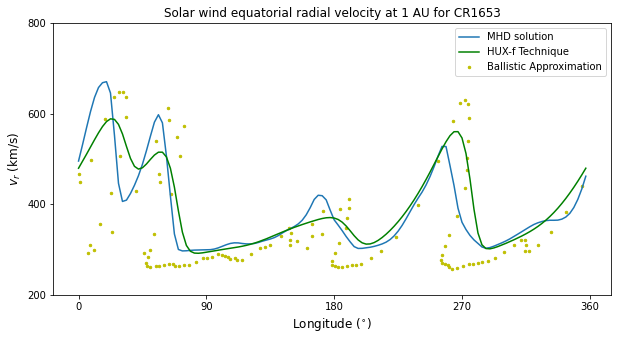

In [17]:
fig, ax = plt.subplots(figsize = (10,5))

_ = ax.plot(p*180/np.pi, solar_equator_r_1_au, label="MHD solution")
_ = ax.plot(p*180/np.pi, apply_forward_upwind_model(solar_equator_r_30_radii, dr_vec, dp_vec),
            'g',label="HUX-f Technique")

_ = ax.scatter(apply_ballistic_approximation(np.array(solar_equator_r_30_radii), 
                r_plot[-1] - r_plot[0], p)*180/np.pi, 
                solar_equator_r_30_radii, 
                color='y',s = 6, label="Ballistic Approximation")
            
_ = ax.set_title("Solar wind equatorial radial velocity at 1 AU for CR" + str(cr) ,fontsize=fs1)
_ = ax.set_xlabel("Longitude ($^{\circ}$)",fontsize=fs1)
_ = ax.set_yticks(ticks=[200, 400, 600, 800])

_ = ax.set_xticks(ticks=[0, 90, 180, 270, 360])
_ = ax.set_ylabel('$v_{r}$ (km/s)',fontsize=fs1)
_ = plt.legend()
plt.savefig('figures/helios1/' + case_study + '/vr_1AU_ts_comp_MHD_HUX-f.png')

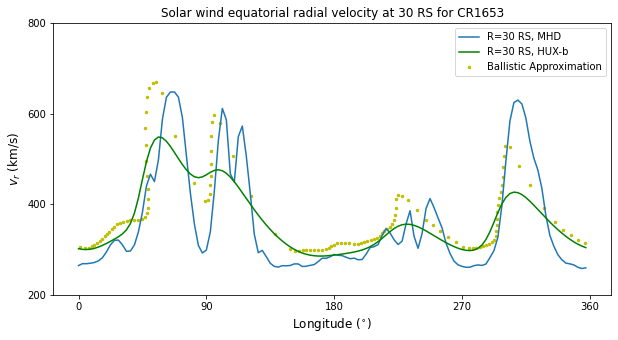

In [18]:
fig, ax = plt.subplots(figsize = (10,5))

_ = ax.plot(p*180/np.pi, solar_equator_r_30_radii , label="R=30 RS, MHD")
_ = ax.plot(p*180/np.pi, apply_backwards_upwind_model(solar_equator_r_1_au, dr_vec, dp_vec),
            'g',label="R=30 RS, HUX-b")


_ = ax.scatter(apply_ballistic_approximation(np.array(solar_equator_r_1_au), 
                r_plot[0]- r_plot[-1], p)*180/np.pi, 
                solar_equator_r_1_au, 
                color='y',s=6, label="Ballistic Approximation")

_ = ax.set_title("Solar wind equatorial radial velocity at 30 RS for CR" + str(cr),fontsize=fs1)
_ = ax.set_xlabel("Longitude ($^{\circ}$)",fontsize=fs1)
_ = ax.set_yticks(ticks=[200, 400, 600, 800])
_ = ax.set_xticks(ticks=[0, 90, 180, 270, 360])
_ = ax.set_ylabel('$v_{r}$ (km/s)',fontsize=fs1)
_ = plt.legend()
#plt.savefig('figures/' + case_study + '/vr_30RS_ts_comp_MHD_HUX-b_cr' + str(cr) +'.png')

In [19]:
# apply the hux technique to all theta slices
hux_f_res, hux_b_res = np.ones((len(p), len(t), len(r))),  np.ones((len(p), len(t), len(r)))
for ii in range(len(t)):
    hux_f_res[:, ii, :] = apply_hux_f_model(f[:, ii, 0], dr_vec, dp_vec).T
    hux_b_res[:, ii, :] = apply_hux_b_model(f[:, ii, -1], dr_vec, dp_vec).T

In [20]:
# force periodicity when plotting
hux_f_res_plot = np.append(hux_f_res,[hux_f_res[0, :, :]], axis=0)
hux_b_res_plot = np.append(hux_b_res,[hux_b_res[0, :, :]], axis=0)

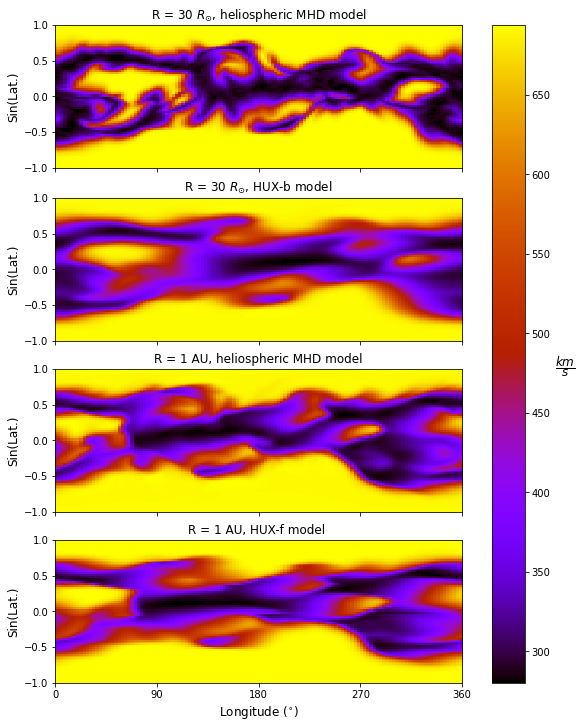

In [21]:
plt.rcParams['figure.figsize'] = [8, 10] # default fig size.

fig, ax = plt.subplots(nrows=4, ncols=1, constrained_layout=True, sharex=True)

ax[0].set_ylim(-1, 1)
ax[0].set_xlim(0, 360)
ax[0].set_title("R = 30 $R_{\odot}$, heliospheric MHD model", fontsize=fs1)
ax[0].set_ylabel("Sin(Lat.)", fontsize=fs1)
ax[0].set_yticks(ticks=[-1, -0.5, 0, 0.5, 1])
ax[0].set_xticks(ticks=[0, 90, 180, 270, 360])
_ = im = ax[0].pcolorfast(ph, th, f_plot[:, :, 0].T, cmap=cmap)

ax[1].set_ylim(-1, 1)
ax[1].set_xlim(0, 360)
ax[1].set_title("R = 30 $R_{\odot}$, HUX-b model", fontsize=fs1)
ax[1].set_ylabel("Sin(Lat.)", fontsize=fs1)
ax[1].set_yticks(ticks=[-1, -0.5, 0, 0.5, 1])
ax[1].set_xticks(ticks=[0, 90, 180, 270, 360])
_ = im = ax[1].pcolorfast(ph, th, hux_b_res_plot[:, :, 0].T, cmap=cmap)


ax[2].set_ylim(-1, 1)
ax[2].set_xlim(0, 360)
ax[2].set_title("R = 1 AU, heliospheric MHD model", fontsize=fs1)
ax[2].set_ylabel("Sin(Lat.)", fontsize=fs1)
ax[2].set_yticks(ticks=[-1, -0.5, 0, 0.5, 1])
ax[2].set_xticks(ticks=[0, 90, 180, 270, 360])
_ = im = ax[2].pcolorfast(ph, th, f_plot[:, :, -1].T, cmap=cmap)


ax[3].set_ylim(-1, 1)
ax[3].set_xlim(0, 360)
ax[3].set_title("R = 1 AU, HUX-f model ", fontsize=fs1)
ax[3].set_ylabel("Sin(Lat.)", fontsize=fs1)
ax[3].set_xlabel("Longitude ($^{\circ}$)", fontsize=fs1)
ax[3].set_yticks(ticks=[-1, -0.5, 0, 0.5, 1])
ax[3].set_xticks(ticks=[0, 90, 180, 270, 360])
_ = im = ax[3].pcolorfast(ph, th, hux_f_res_plot[:, :, -1].T, cmap=cmap)
cbar = fig.colorbar(im, ax=ax.flat)
cbar.set_label('$\dfrac{km}{s}$', fontsize=fs1, rotation=360, labelpad=15)

plt.savefig('figures/helios1/' + case_study + '/vr_lon_lat_maps_MHD_HUX.png')

# Read in Helios 1 observations

In [22]:
helios1_data = helios.merged(1, starttime, endtime)
print("Available data = ", helios1_data.columns)

Available data =  ['R_Helio', 'ESS_Ang', 'clong', 'clat', 'HGIlong', 'B_R', 'B_T', 'B_N', 'Vp_R', 'Vp_T', 'Vp_N', 'crot', 'Np', 'Vp', 'Tp', 'V_Azimuth', 'V_Elev', 'B_x', 'B_y', 'B_z', 'stdev_B_x', 'stdev_B_y', 'stdev_B_z', 'N_a', 'V_a', 'T_a', 'Np2', 'Vp2']


In [23]:
helios1_data.data

,R_Helio,ESS_Ang,clong,clat,HGIlong,B_R,B_T,B_N,Vp_R,Vp_T,...,B_y,B_z,stdev_B_x,stdev_B_y,stdev_B_z,N_a,V_a,T_a,Np2,Vp2
Time,,,,,,,,,,,,,,,,,,,,,
1977-03-23 00:01:07,0.53,333.470001,344.589996,-7.11,80.511597,3.760000,-17.629999,7.88,390.698914,-33.632099,...,17.629999,7.88,1.20,0.94,2.54,0.70,392.500000,238853.0,32.160000,393.299988
1977-03-23 00:02:28,0.53,333.470001,344.579987,-7.11,80.514900,5.340000,-18.389999,3.14,386.804688,-32.956902,...,18.389999,3.14,0.38,0.51,1.17,0.83,381.000000,259006.0,30.930000,391.000000
1977-03-23 00:03:49,0.53,333.470001,344.570007,-7.11,80.518204,4.390000,-17.410000,5.34,391.316895,-24.756701,...,17.410000,5.34,3.46,2.40,6.86,0.64,389.500000,201612.0,27.480000,391.200012
1977-03-23 00:05:10,0.53,333.470001,344.559998,-7.11,80.521500,5.580000,-16.940001,8.32,386.335205,-26.270000,...,16.940001,8.32,0.75,0.62,1.04,NaN,NaN,NaN,27.930000,388.500000
1977-03-23 00:06:31,0.53,333.470001,344.549988,-7.11,80.524803,2.450000,-19.200001,-0.73,382.690704,-32.740898,...,19.200001,-0.73,0.65,0.23,2.02,NaN,NaN,NaN,28.830000,387.399994
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1977-04-19 23:57:00,0.34,88.459999,89.959999,4.87,223.004196,29.139999,-25.320000,-3.90,351.664093,35.162701,...,25.320000,-3.90,1.42,1.06,2.16,13.05,316.899994,153249.0,53.639999,343.600006
1977-04-19 23:57:40,0.34,88.459999,89.949997,4.87,223.000702,28.389999,-25.459999,-5.20,355.308197,34.713100,...,25.459999,-5.20,0.49,0.40,0.74,NaN,NaN,NaN,57.160000,350.399994
1977-04-19 23:58:21,0.34,88.459999,89.949997,4.87,223.007507,29.160000,-25.969999,-4.34,355.760315,43.051701,...,25.969999,-4.34,1.45,1.34,2.02,NaN,NaN,NaN,51.610001,346.000000


Generate the Helios 1 trajectory in Heliographic (rotating) Coordinate System (HG).

We take the timestamps from the previously loaded data, and use `heliopy.spice`
to generate the trajectory at these times.

In [24]:
times = helios1_data.index

spicedata.get_kernel('helios1')
helios1_traj = spice.Trajectory('Helios 1')
helios1_traj.generate_positions(times=times, observing_body='Sun', frame='IAU_SUN')
helios1_coords = helios1_traj.coords

Here we sample the MHD and HUX velocity results at Helios 1 location. 


In [25]:
hux_f_model = copy.deepcopy(vr_model)
hux_f_model.data.data = hux_f_res

hux_b_model = copy.deepcopy(vr_model)
hux_b_model.data.data = hux_b_res

In [26]:
vr_sampled_hux_f = hux_f_model.sample_at_coords(helios1_coords.lon,
                                                helios1_coords.lat,
                                                helios1_coords.radius)

vr_sampled_hux_b = hux_b_model.sample_at_coords(helios1_coords.lon,
                                                helios1_coords.lat,
                                                helios1_coords.radius)

vr_sampled_mhd = vr_model.sample_at_coords(helios1_coords.lon,
                                           helios1_coords.lat,
                                           helios1_coords.radius)

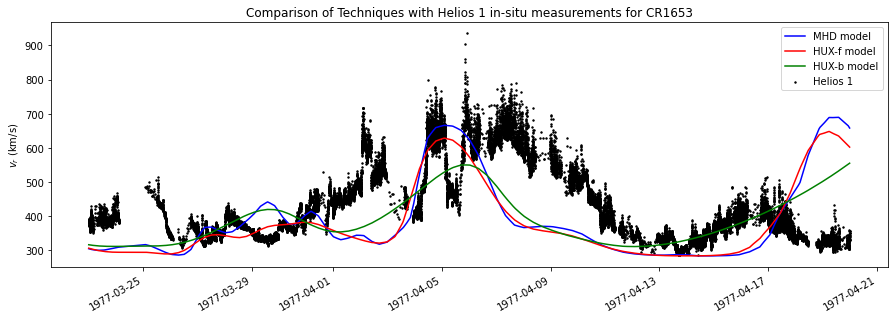

In [27]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(times, vr_sampled_mhd, color="b", label='MHD model')
ax.plot(times, vr_sampled_hux_f, color="r",label='HUX-f model')
ax.plot(times, vr_sampled_hux_b, color="g",label='HUX-b model')
ax.scatter(times, helios1_data.quantity('Vp_R'), color="k",s=2,  label='Helios 1')

ax.set_ylabel(r'$v_{r}$ (km/s)')
ax.legend()
ax.set_title("Comparison of Techniques with Helios 1 in-situ measurements for CR" + str(cr))
fig.autofmt_xdate()

plt.savefig('figures/helios1/'+ case_study + '/helios1_comparison_cr'+ str(cr)+ '_time.png')

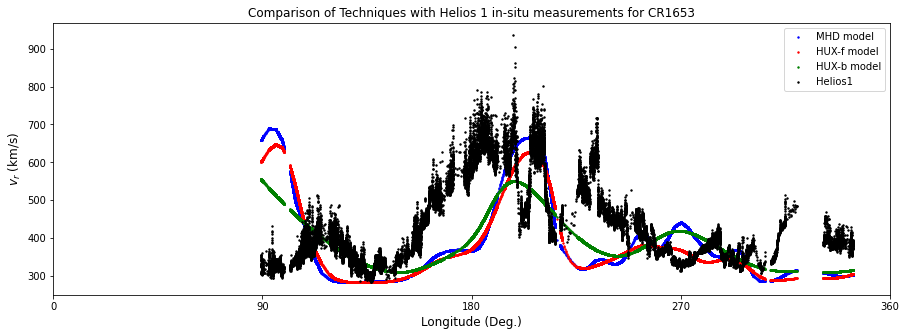

In [28]:
fig, ax = plt.subplots(figsize=(15, 5))
size = 2

ax.scatter(helios1_coords.lon, vr_sampled_mhd, color="b", s=size, label="MHD model")
ax.scatter(helios1_coords.lon, vr_sampled_hux_f, color="r", s=size, label="HUX-f model")
ax.scatter(helios1_coords.lon, vr_sampled_hux_b, color="g",s=size,  label="HUX-b model")
ax.scatter(helios1_coords.lon, helios1_data.quantity('Vp_R'), color="k",s=size,  label="Helios1")


ax.set_ylabel(r'$v_{r}$ (km/s)', fontsize=fs1)
ax.set_xticks(ticks=[0, 90, 180, 270, 360])
ax.set_xlabel("Longitude (Deg.)", fontsize=fs1)
ax.set_title("Comparison of Techniques with Helios 1 in-situ measurements for CR" + str(cr))
ax.legend()
plt.savefig('figures/helios1/'+ case_study + '/helios1_comparison_cr' + str(cr) + '_carrington_longitude.png')

# Read in OMNI (Earth) Observations

• OMNI data set for solar wind speed observations can be found https://spdf.gsfc.nasa.gov/pub/data/omni/low_res_omni/

In [29]:
omni_data = omni.h0_mrg1hr(starttime, endtime)

In [30]:
omni_data.data

,Epoch_1800,Rot1800,IMF1800,PLS1800,IMF_PTS1800,PLS_PTS1800,ABS_B1800,F1800,THETA_AV1800,PHI_AV1800,...,F10_INDEX,KP,DST,AE,AP_INDEX,AL_INDEX,AU_INDEX,PC_N_INDEX,Solar_Lyman_alpha,Proton_QI
Time,,,,,,,,,,,,,,,,,,,,,
1977-03-23 01:00:00,6.239515e+13,1964,50,50,60,52,3.9,3.7,-33.900002,2.000000,...,74.699997,17,-13,9999,6,99999,99999,0.7,0.006277,0.0074
1977-03-23 02:00:00,6.239515e+13,1964,50,50,60,51,2.9,2.7,-43.000000,38.000000,...,74.699997,17,-10,9999,6,99999,99999,1.1,0.006277,0.0040
1977-03-23 03:00:00,6.239516e+13,1964,50,50,60,47,3.5,3.4,-40.500000,45.400002,...,74.699997,13,-9,9999,5,99999,99999,0.7,0.006277,0.0065
1977-03-23 04:00:00,6.239516e+13,1964,50,50,60,49,3.7,3.1,-31.700001,26.700001,...,74.699997,13,-9,9999,5,99999,99999,0.9,0.006277,0.0066
1977-03-23 05:00:00,6.239516e+13,1964,50,50,31,47,3.3,2.9,-52.700001,20.700001,...,74.699997,13,-9,9999,5,99999,99999,1.1,0.006277,0.0040
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1977-04-19 19:00:00,6.239755e+13,1965,99,44,999,12,NaN,NaN,NaN,NaN,...,79.800003,37,-69,9999,22,99999,99999,1.5,0.006341,NaN
1977-04-19 20:00:00,6.239755e+13,1965,99,44,999,14,NaN,NaN,NaN,NaN,...,79.800003,37,-65,9999,22,99999,99999,1.7,0.006341,NaN
1977-04-19 21:00:00,6.239755e+13,1965,99,44,999,16,NaN,NaN,NaN,NaN,...,79.800003,47,-69,9999,39,99999,99999,1.1,0.006341,NaN


Generate the OMNI (Earth) trajectory in Heliographic (rotating) Coordinate System (HG).

We take the timestamps from the previously loaded data, and use `heliopy.spice`
to generate the trajectory at these times.

In [31]:
earth_traj = spice.Trajectory('Earth')
earth_traj.generate_positions(times=omni_data.index, observing_body='Sun', frame='IAU_SUN')
earth_coords = earth_traj.coords

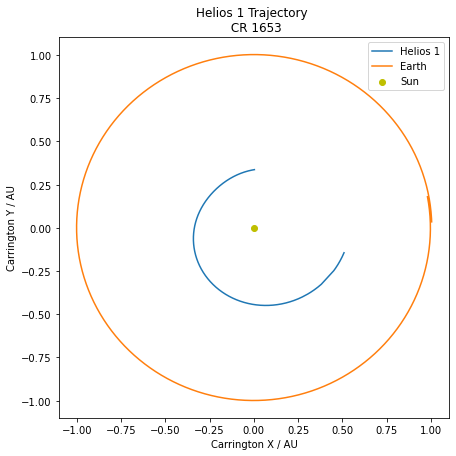

In [32]:
fig, ax = plt.subplots(figsize=(7, 7))
_ = ax.plot(helios1_coords.radius.to("AU")* np.cos(helios1_coords.lon.to(u.rad)), helios1_coords.radius.to("AU")* np.sin(helios1_coords.lon.to(u.rad)), label="Helios 1")
_ = ax.plot(earth_coords.radius.to("AU")* np.cos(earth_coords.lon.value*np.pi/180), earth_coords.radius.to("AU")* np.sin(earth_coords.lon.value*np.pi/180), label="Earth")
_ = ax.scatter(0, 0, color="y", label="Sun")
_ = ax.set_xlabel("Carrington X / AU")
_ = ax.set_ylabel("Carrington Y / AU")
_ = ax.legend()
_ = ax.set_title("Helios 1 Trajectory \n CR " + str(cr))
plt.savefig('figures/helios1/'+ case_study + '/helios1_trajectory_location.png')

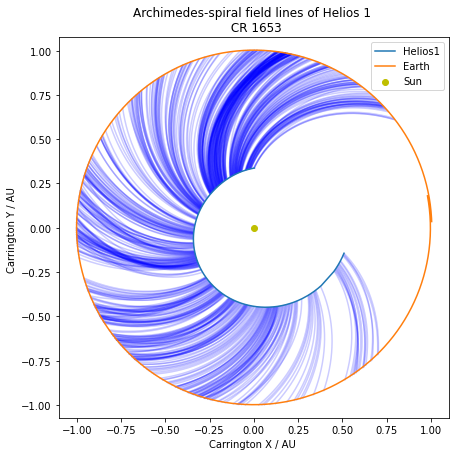

In [33]:
nphi = len(helios1_coords.lon.to(u.rad))
nrout = 201
earth_mean_r = np.mean(earth_coords.radius.to("AU").value)

fig, ax = plt.subplots(figsize=(7, 7))
for ii in np.arange(0, nphi, 50):
    # helios longitude location. 
    phi_location = (helios1_coords.lon.to(u.rad)[ii]).value
    # radial vector 
    radial_location = np.linspace(helios1_coords.radius.to("AU").value[ii], earth_mean_r, nrout)
    # convert units to km
    radial_location = radial_location * (u.AU)
    radial_location = radial_location.to(u.km)
    # vr 
    curr_velocity = helios1_data.quantity('Vp_R').value[ii]

    if not np.isnan(curr_velocity):
        phi_shift_vec = compute_phi_shift_forward(p=phi_location, 
                                                     r=radial_location.value,
                                                     v=curr_velocity) 

        x = np.cos(phi_shift_vec)*radial_location.to(u.AU)
        y = np.sin(phi_shift_vec)*radial_location.to(u.AU)

        _ = ax.plot(x[1:], y[1:], c="b", alpha=0.2)

ax.plot(helios1_coords.radius.to("AU")* np.cos(helios1_coords.lon.to(u.rad)), helios1_coords.radius.to("AU")* np.sin(helios1_coords.lon.to(u.rad)), label="Helios1")
ax.plot(earth_coords.radius.to("AU")* np.cos(earth_coords.lon.value*np.pi/180), earth_coords.radius.to("AU")* np.sin(earth_coords.lon.value*np.pi/180), label="Earth")
ax.scatter(0, 0, color="y", label="Sun")
ax.set_title("Archimedes-spiral field lines of Helios 1 \n CR " + str(cr))
ax.set_xlabel("Carrington X / AU ")
ax.set_ylabel("Carrington Y / AU ")
plt.axis("equal")
plt.legend()

plt.savefig('figures/helios1/'+ case_study + '/Archimedes_spiral_helios1.png')

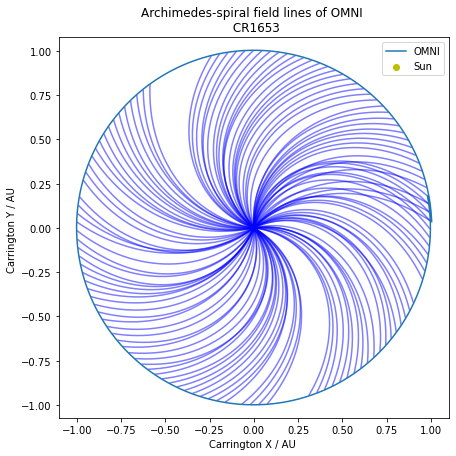

In [34]:
fig, ax = plt.subplots(figsize=(7, 7))
for ii in np.arange(0, len(earth_coords.lon), 5):
    # phi-location oomni
    phi_location = (earth_coords.lon.value[ii])*(np.pi/180)
    # radial vector
    radial_location = np.linspace(earth_coords.radius.to("AU").value[ii], 0, nrout)
    radial_location = radial_location * (u.AU)
    radial_location = radial_location.to(u.km)
    # current velocity
    curr_velocity = omni_data.quantity('V').value[ii]

    if not np.isnan(curr_velocity):
        phi_shift_vec = compute_phi_shift_forward(p=phi_location, 
                                                     r=radial_location.value,
                                                     v=curr_velocity) 

        x = np.cos(phi_shift_vec)*radial_location.to(u.AU)
        y = np.sin(phi_shift_vec)*radial_location.to(u.AU)

        _ = ax.plot(x[1:], y[1:], c="b", alpha=0.5)

ax.plot(earth_coords.radius.to("AU")* np.cos(earth_coords.lon.value*np.pi/180), earth_coords.radius.to("AU")* np.sin(earth_coords.lon.value*np.pi/180), label="OMNI")
ax.scatter(0, 0, color="y", label="Sun")
ax.set_title("Archimedes-spiral field lines of OMNI \n CR" + str(cr))
ax.set_xlabel("Carrington X / AU ")
ax.set_ylabel("Carrington Y / AU ")
plt.axis("equal")
plt.legend()

plt.savefig('figures/helios1/'+ case_study + '/Archimedes_spiral_omni.png')

In [35]:
vr_sampled_hux_f_omni = hux_f_model.sample_at_coords(earth_coords.lon,
                                                     earth_coords.lat,
                                                     earth_coords.radius)

vr_sampled_hux_b_omni = hux_b_model.sample_at_coords(earth_coords.lon,
                                                     earth_coords.lat,
                                                     earth_coords.radius)

vr_sampled_mhd_omni = vr_model.sample_at_coords(earth_coords.lon,
                                                earth_coords.lat,
                                                earth_coords.radius)

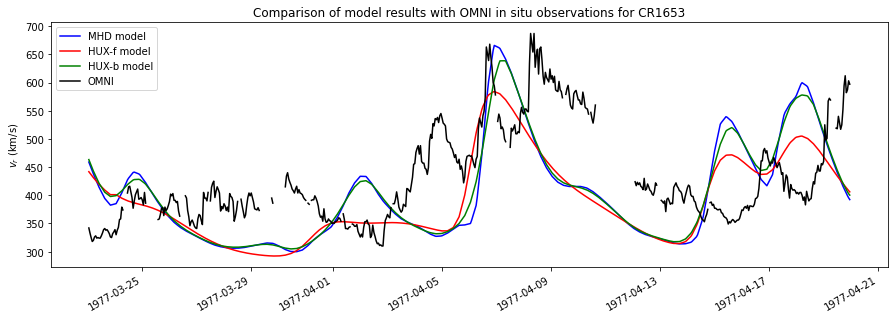

In [36]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(omni_data.index, vr_sampled_mhd_omni, color="b", label='MHD model')
ax.plot(omni_data.index, vr_sampled_hux_f_omni, color="r", label='HUX-f model')
ax.plot(omni_data.index, vr_sampled_hux_b_omni, color="g", label='HUX-b model')
ax.plot(omni_data.index, omni_data.quantity('V'),color="k", label='OMNI')

ax.set_ylabel(r'$v_{r}$ (km/s)')
ax.legend()
ax.set_title("Comparison of model results with OMNI in situ observations for CR" + str(cr))
fig.autofmt_xdate()

plt.savefig('figures/helios1/'+ case_study + '/omni_comparison_cr' + str(cr) + '_time.png')

In [37]:
min_index = np.argmin(earth_coords.lon)

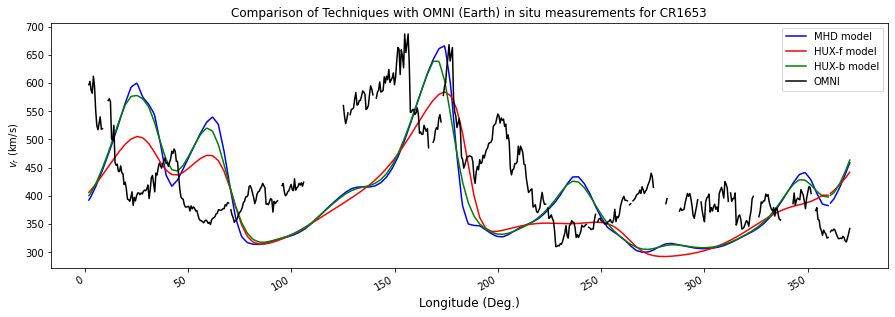

In [38]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(np.array(earth_coords.lon[:min_index])+360, vr_sampled_mhd_omni[:min_index], color="b", label="MHD model")
ax.plot(np.array(earth_coords.lon[:min_index])+360, vr_sampled_hux_f_omni[:min_index], color="r", label="HUX-f model")
ax.plot(np.array(earth_coords.lon[:min_index])+360, vr_sampled_hux_b_omni[:min_index], color="g", label="HUX-b model")
ax.plot(np.array(earth_coords.lon[:min_index])+360, omni_data.quantity('V')[:min_index], color="k", label="OMNI")

ax.plot(earth_coords.lon[min_index+1:], vr_sampled_mhd_omni[min_index+1:], color="b")
ax.plot(earth_coords.lon[min_index+1:], vr_sampled_hux_f_omni[min_index+1:], color="r")
ax.plot(earth_coords.lon[min_index+1:], vr_sampled_hux_b_omni[min_index+1:], color="g")
ax.plot(earth_coords.lon[min_index+1:], omni_data.quantity('V')[min_index+1:], color="k")

ax.set_ylabel(r'$v_{r}$ (km/s)')
ax.set_xlabel("Longitude (Deg.)", fontsize=fs1)
ax.legend()
ax.set_title("Comparison of Techniques with OMNI (Earth) in situ measurements for CR" + str(cr))
fig.autofmt_xdate()


plt.savefig('figures/helios1/'+ case_study + '/omni_comparison_cr' + str(cr) + '_lon.png')

# Mapping Helios1 to OMNI (Earth) using the HUX-f and Ballistic Technique

# Assumptions: 
#### 1.  Latitude is constant in Helios1 trajectory coordinates 
* Note that HUX is dependent on $\phi$ and $r$ only. 

#### 2.  Helios1 and Earth are aligned in latitude. 

#### 3.  $\phi$ is monotonically increasing.

#### 4. Periodic Boundary Conditions

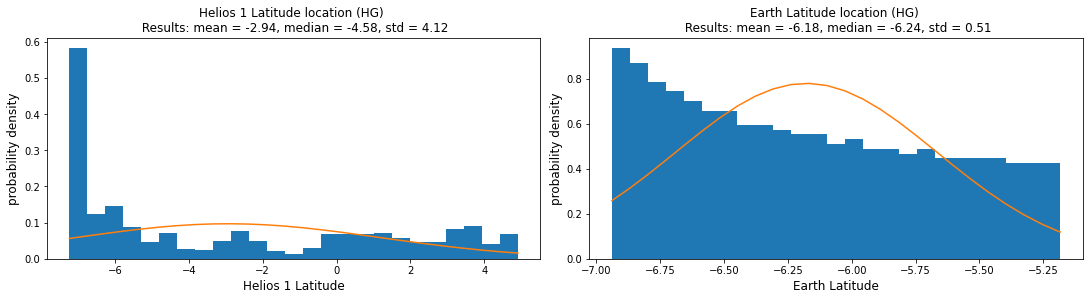

In [39]:
fig, ax = plt.subplots(nrows=1, ncols=2, constrained_layout=True, figsize=(15, 4))


## helios latitude trajectory 
mu, sigma = scipy.stats.norm.fit(helios1_traj.coords.lat.value)

n , bins, _ = ax[0].hist(helios1_traj.coords.lat.value, 25, density=1)
_ = ax[0].set_title("Helios 1 Latitude location (HG) \n Results: mean = %.2f, median = %.2f, std = %.2f" % \
                       (mu, np.median(helios1_traj.coords.lat.value), sigma), fontsize=fs1)
_ = ax[0].set_xlabel("Helios 1 Latitude", fontsize=fs1)
_ = ax[0].set_ylabel("probability density", fontsize=fs1)

best_fit_line = scipy.stats.norm.pdf(bins, mu, sigma)
_ = ax[0].plot(bins, best_fit_line)


## earth latitude trajectory 
mu, sigma = scipy.stats.norm.fit(earth_traj.coords.lat.value)

n , bins, _ = ax[1].hist(earth_traj.coords.lat.value, 25, density=1)
_ = ax[1].set_title("Earth Latitude location (HG) \n Results: mean = %.2f, median = %.2f, std = %.2f" % \
                       (mu, np.median(earth_traj.coords.lat.value), sigma), fontsize=fs1)
_ = ax[1].set_xlabel("Earth Latitude", fontsize=fs1)
_ = ax[1].set_ylabel("probability density", fontsize=fs1) 

best_fit_line = scipy.stats.norm.pdf(bins, mu, sigma)
_ = ax[1].plot(bins, best_fit_line)

plt.savefig('figures/helios1/'+ case_study + '/helios1_earth_lat_traj' + str(cr) + '_lon.png', dpi=300)

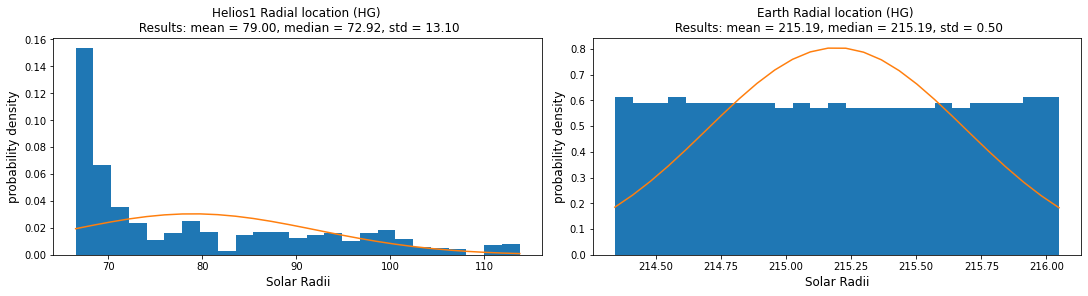

In [40]:
fig, ax = plt.subplots(nrows=1, ncols=2, constrained_layout=True, figsize=(15, 4))


## helios radial trajectory 
mu, sigma = scipy.stats.norm.fit(helios1_traj.coords.radius.to(u.solRad).value)

n , bins, _ = ax[0].hist(helios1_traj.coords.radius.to(u.solRad).value, 25, density=1)
_ = ax[0].set_title("Helios1 Radial location (HG) \n Results: mean = %.2f, median = %.2f, std = %.2f" % \
                       (mu, np.median(helios1_traj.coords.radius.to(u.solRad).value), sigma), fontsize=fs1)
_ = ax[0].set_xlabel("Solar Radii", fontsize=fs1) 
_ = ax[0].set_ylabel("probability density", fontsize=fs1) 

best_fit_line = scipy.stats.norm.pdf(bins, mu, sigma)
_ = ax[0].plot(bins, best_fit_line)


## earth radial trajectory 
mu, sigma = scipy.stats.norm.fit(earth_traj.coords.radius.to(u.solRad).value)

n , bins, _ = ax[1].hist(earth_traj.coords.radius.to(u.solRad).value, 25, density=1)
_ = ax[1].set_title("Earth Radial location (HG) \n Results: mean = %.2f, median = %.2f, std = %.2f" % \
                       (mu, np.median(earth_traj.coords.radius.to(u.solRad).value), sigma), fontsize=fs1) 
_ = ax[1].set_xlabel("Solar Radii", fontsize=fs1) 
_ = ax[1].set_ylabel("probability density", fontsize=fs1) 

best_fit_line = scipy.stats.norm.pdf(bins, mu, sigma)
_ = ax[1].plot(bins, best_fit_line)

plt.savefig('figures/helios1/'+ case_study + '/helios1_earth_rad_traj' + str(cr) + '_lon.png')

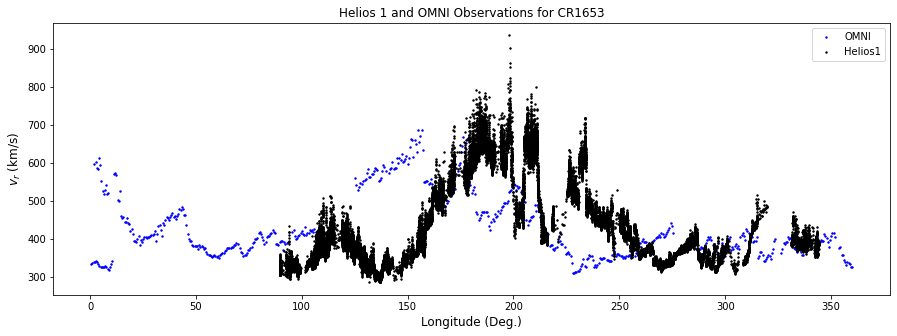

In [41]:
fig, ax = plt.subplots(figsize=(15, 5))

_ = ax.scatter(earth_coords.lon, omni_data.quantity('V'), color="b", s=size, label="OMNI")
_ = ax.scatter(helios1_coords.lon, helios1_data.quantity('Vp_R'), color="k", s=size, label="Helios1")

_ = ax.set_ylabel(r'$v_{r}$ (km/s)', fontsize=fs1)
_ = ax.set_xlabel("Longitude (Deg.)", fontsize=fs1)
_ = ax.legend()
_ = ax.set_title("Helios 1 and OMNI Observations for CR" + str(cr), fontsize=fs1) 
plt.savefig('figures/helios1/'+ case_study + '/omni_and_helios1_vr_vs_carringtonlon' + str(cr) +'.png')

# Ballistic Mapping
 * Evaluate the characteristic lines - do they intersect? This happens when the Helios1 velocity function is decreasing. Otherwise, when the Helios velocity function is increasing it results in rarefaction wave. 
 

In [42]:
r_mean = np.linspace(np.mean(helios1_coords.radius), np.mean(earth_coords.radius), 100)
r_min = np.linspace(np.min(helios1_coords.radius), np.mean(earth_coords.radius), 100)
r_max = np.linspace(np.max(helios1_coords.radius), np.mean(earth_coords.radius), 100)

In [43]:
omega_rot = (2 * np.pi) / (25.38 * 86400)

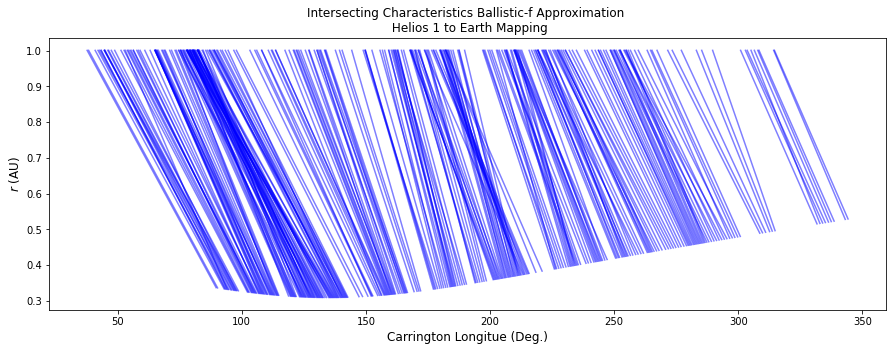

In [44]:
fig, ax = plt.subplots(figsize = (15,5))


for ii in np.arange(0, nphi, 100):
    # helios lon location
    phi_location = (helios1_coords.lon.to(u.rad)[ii]).value
    # radial vector
    radial_location = np.linspace(helios1_coords.radius.to("AU").value[ii], earth_mean_r, nrout)
    # convert to km. 
    radial_location = radial_location * (u.AU)
    radial_location = radial_location.to(u.km)
    # current velocity
    curr_velocity = helios1_data.quantity('Vp_R').value[ii]

    if not np.isnan(curr_velocity):
        phi_shift_vec = compute_phi_shift_forward(p=phi_location, 
                                                     r=radial_location.value,
                                                     v=curr_velocity) 
        
        _ = ax.plot(phi_shift_vec*(180/np.pi), radial_location.to(u.AU), c="b", alpha=0.5)

_ = ax.set_xlabel("Carrington Longitue (Deg.)", fontsize=fs1) 
_ = ax.set_ylabel("$r$ (AU)", fontsize=fs1) 
_ = ax.set_title("Intersecting Characteristics Ballistic-f Approximation \n Helios 1 to Earth Mapping", fontsize=fs1) 
plt.savefig('figures/helios1/'+ case_study + '/intersecting_characteristics_ballistic_f' + str(cr) +'.png')

In [ ]:
res_ballistic_f = np.zeros(nphi)

for ii in range(nphi):
    # phi location
    phi_location = (helios1_coords.lon.to(u.rad)[ii]).value
    r0 = helios1_coords.radius.value[ii]
    rf = earth_mean_r *(u.AU)
    rf = rf.to(u.km).value
    curr_velocity = helios1_data.quantity('Vp_R').value[ii]
    dr = rf - r0
    delta_phi = (omega_rot * dr) / curr_velocity
    phi_shifted = phi_location - delta_phi
    # force periodicity
    res_ballistic_f[ii] = phi_shifted % (2 * np.pi)

<ipython-input-45-31d82a24dc1e>:14: RuntimeWarning: invalid value encountered in double_scalars
  res_ballistic_f[ii] = phi_shifted % (2 * np.pi)


In [ ]:
fig, ax = plt.subplots(figsize=(15, 5))
_ = ax.scatter(np.array(earth_coords.lon), omni_data.quantity('V'), color="b", s=size, label="OMNI")

_ = ax.scatter(res_ballistic_f*(180/np.pi), helios1_data.quantity('Vp_R'),s=2, label="Ballistic-f")

_ = ax.set_xticks(ticks=[0, 90, 180, 270, 360])
_ = ax.set_title("Mapping from Helios1 to OMNI (Earth) using the simple Ballistic-f Technique")
_ = ax.set_ylabel(r'$v_{r}$ (km/s)', fontsize=fs1)
_ = ax.set_xlabel("Longitude (Deg.)", fontsize=fs1)
_ = ax.legend()


# HUX-f Technique
# 1D interpolation - input $\phi$ ranges from [0, 2$\pi$]

In [ ]:
# get longitude limits
min_lon = np.inf
max_lon = -np.inf

for ii in range(len(helios1_coords.lon.value)):
    if helios1_coords.lon.value[ii] < min_lon and not math.isnan(helios1_data.quantity('Vp_R').value[ii]):
        min_lon = helios1_coords.lon.value[ii]
    if helios1_coords.lon.value[ii] > max_lon and not math.isnan(helios1_data.quantity('Vp_R').value[ii]):
        max_lon = helios1_coords.lon.value[ii]

In [ ]:
# create uniform phi 1d mesh grid. 
phi_array = np.linspace(0, 360, 361)

In [ ]:
# drop NaNs
nan_idx = np.isfinite(helios1_data.quantity('Vp_R').value)
v_vec = helios1_data.quantity('Vp_R').value[nan_idx]
interp = interpolate.interp1d(helios1_coords.lon.value[nan_idx], \
                              v_vec, fill_value=(400, 400),  bounds_error=False)
helios1_interp = interp(phi_array)

In [ ]:
# convert to radians
p_hux = phi_array * np.pi/180
# delta phi 
dp_vec_hux = p_hux[1:] - p_hux[:-1]

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(phi_array, helios1_interp)
ax.scatter(helios1_coords.lon.value, helios1_data.quantity('Vp_R').value, s=1)
ax.set_xlim(min_lon, max_lon)

In [ ]:
res_hux_f_min = apply_forward_upwind_model(r_initial=helios1_interp,
                                        dr_vec=r_min.value[1:] - r_min.value[:-1],
                                        dp_vec=dp_vec_hux, 
                                        add_v_acc=False, 
                                        r0=r_min[0].value)


res_hux_f_max = apply_forward_upwind_model(r_initial=helios1_interp,
                                        dr_vec=r_max.value[1:] - r_max.value[:-1],
                                        dp_vec=dp_vec_hux, 
                                        add_v_acc=False, 
                                        r0=r_max[0].value)


res_hux_f_mean = apply_forward_upwind_model(r_initial=helios1_interp,
                                        dr_vec=r_mean.value[1:] - r_mean.value[:-1],
                                        dp_vec=dp_vec_hux, 
                                        add_v_acc=False, 
                                        r0=r_mean[0].value)

In [ ]:
fig, ax = plt.subplots(figsize=(12,4))
_ = ax.scatter(np.array(earth_coords.lon), omni_data.quantity('V'), color="b", s=size, label="OMNI")

_ = ax.plot(phi_array, res_hux_f_mean, color="r", label="HUX-f mean")
_ = ax.plot(phi_array, res_hux_f_min, color="g", label="HUX-f min")
_ = ax.plot(phi_array, res_hux_f_max, color="m", label="HUX-f max")

#_ = ax.scatter(res_ballistic_f*(180/np.pi), helios1_data.quantity('Vp_R').value, s=2, c="k", label="Ballistic-f")

_ = ax.set_xlim(np.nanmin(res_ballistic_f*(180/np.pi)), np.nanmax(res_ballistic_f*(180/np.pi)))

_ = ax.set_title("Mapping from Helios 1 to OMNI (Earth) for CR" + str(cr)+ "\n $r_{min}$ = %.2f $R_\odot$, $r_{mean}$ = %.2f $R_\odot$, $r_{max}$ = %.2f $R_\odot$" % \
                       (np.min(helios1_coords.radius).to(u.solRad).value,
                        np.mean(helios1_coords.radius).to(u.solRad).value,
                        np.max(helios1_coords.radius).to(u.solRad).value))
                 
_ = ax.set_ylabel(r'$v_{r}$ (km/s)', fontsize=fs1)
_ = ax.set_xlabel("Longitude (Deg.)", fontsize=fs1)
_ = ax.legend()

plt.savefig('figures/helios1/'+ case_study + '/helios1_to_omni_mapping' + str(cr) + '_lon.png', dpi=200)

# Map OMNI to Helios1 using the HUX-b and Ballistic Techniques

# Ballistic Mapping
 * evaluate the characteristic lines - do they intersect? This happens when the OMNI velocity function is increasing. Otherwise, when the OMNI velocity function is decreasing it results in rarefaction wave. 
 

In [ ]:
fig, ax = plt.subplots(figsize = (15,5))


for ii in np.arange(0, len(earth_coords.lon), 5):
    phi_location = (earth_coords.lon[ii].value)*(np.pi/180)
    radial_location = np.linspace(earth_coords.radius.to(u.km)[ii], r_min[0].to(u.km), nrout)
    curr_velocity = omni_data.quantity('V').value[ii]

    if not np.isnan(curr_velocity):
        phi_shift_vec = compute_phi_shift_forward(p=phi_location, 
                                                     r=radial_location.value,
                                                     v=curr_velocity) 
        _ = ax.plot(phi_shift_vec*(180/np.pi), radial_location.to(u.AU))

_ = ax.set_xlabel("Carrington Longitue (Deg.)", fontsize=fs1) 
_ = ax.set_ylabel("$r$ (AU)", fontsize=fs1) 
_ = ax.set_title("Intersecting Characteristics Ballistic-b Approximation \n Earth to Helios 1 Mapping", fontsize=fs1) 
plt.savefig('figures/helios1/'+ case_study + '/intersecting_characteristics_ballistic_b' + str(cr) +'.png')

# HUX-b Technique

# 1D interpolation - input $\phi$ ranges from [0, 2$\pi$]

In [ ]:
# drop NaNs
nan_idx = np.isfinite(omni_data.quantity('V').value)
v_vec = omni_data.quantity('V').value[nan_idx]
interp = interpolate.interp1d(earth_coords.lon.value[nan_idx], \
                              v_vec, fill_value=(400, 400),  bounds_error=False)
omni_interp = interp(phi_array)

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(phi_array, omni_interp)
ax.scatter(earth_coords.lon.value, omni_data.quantity('V').value)

In [ ]:
hux_b_full_res = apply_hux_b_model(r_final=omni_interp, 
                                         dr_vec=r_min.value[1:] - r_min.value[:-1], 
                                         dp_vec=dp_vec_hux, 
                                         r0=r_min[0].value, 
                                         add_v_acc=False).T

In [ ]:
points = (phi_array, r_min)
xi = (helios1_coords.lon.value, helios1_coords.radius.value)
res_hux_b_interp = interpolate.interpn(points, hux_b_full_res, xi)

In [ ]:
ballf = interpolate.interp1d(helios1_coords.lon.to(u.rad), helios1_coords.radius.to(u.km), fill_value="extrapolate")
helios1_r_new = ballf(earth_coords.lon.to(u.rad))

In [ ]:
res_ballistic_b = np.zeros(len(earth_coords.radius))

for ii in range(len(earth_coords.radius)):
    phi_location = (earth_coords.lon[ii].to(u.rad)).value
    r0 = earth_coords.radius.value[ii]
    rf = helios1_r_new[ii]
    curr_velocity = omni_data.quantity('V').value[ii]
    dr = rf - r0
    
    delta_phi = (omega_rot * dr) / curr_velocity
    phi_shifted = phi_location - delta_phi
    # force periodicity
    res_ballistic_b[ii] = phi_shifted % (2 * np.pi)

In [ ]:
res_hux_b_min = apply_backwards_upwind_model(r_final=omni_interp, 
                                         dr_vec=r_min.value[1:] - r_min.value[:-1], 
                                         dp_vec=dp_vec_hux, 
                                         r0=r_min[0].value, 
                                         add_v_acc=False)

res_hux_b_mean = apply_backwards_upwind_model(r_final=omni_interp, 
                                         dr_vec=r_mean.value[1:] - r_mean.value[:-1], 
                                         dp_vec=dp_vec_hux, 
                                         r0=r_mean[0].value, 
                                         add_v_acc=False)

res_hux_b_max = apply_backwards_upwind_model(r_final=omni_interp, 
                                         dr_vec=r_max.value[1:] - r_max.value[:-1], 
                                         dp_vec=dp_vec_hux, 
                                         r0=r_max[0].value, 
                                         add_v_acc=False)

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5))
_ = ax.scatter(helios1_coords.lon, helios1_data.quantity('Vp_R'), color="b", s=size, label="Helios1")
_ = ax.scatter(res_ballistic_b*(180/np.pi), omni_data.quantity('V').value, s=2,label="Ballistic-b exact")

_ = ax.set_xticks(ticks=[0, 90, 180, 270, 360])
_ = ax.set_title("Mapping from OMNI (Earth) to Helios1 using Ballistic-b Technique")
_ = ax.set_ylabel(r'$v_{r}$ (km/s)', fontsize=fs1)
_ = ax.set_xlabel("Longitude (Deg.)", fontsize=fs1)
_ = ax.legend()

In [ ]:
fig, ax = plt.subplots(figsize=(15, 7))
_ = ax.scatter(np.array(helios1_coords.lon), helios1_data.quantity('Vp_R'), color="b", s=size, label="Helios1")

_ = ax.plot(phi_array, res_hux_b_mean, color="r", label="HUX-b mean")
_ = ax.plot(phi_array, res_hux_b_min, color="g", label="HUX-b min")
_ = ax.plot(phi_array, res_hux_b_max, color="m", label="HUX-b max")
_ = ax.scatter(helios1_coords.lon.value, res_hux_b_interp, color="k", s=2, label="HUX-b interp")

#_ = ax.scatter(res_ballistic_b_max, omni_data.quantity('V'),s=2, label="Ballistic-b max")
#_ = ax.scatter(res_ballistic_b_mean, omni_data.quantity('V'), s=2,label="Ballistic-b mean")
#_ = ax.scatter(res_ballistic_b_min, omni_data.quantity('V').value, s=2,label="Ballistic-b min")
_ = ax.scatter(res_ballistic_b *(180/np.pi), omni_data.quantity('V').value, color="y", s=2,label="Ballistic-b")


_ = ax.set_title("Mapping from OMNI (Earth) to Helios1 for CR" + str(cr) +"\n $r_{mean}$ = %.2f  $R_\odot$, $r_{min}$ = %.2f  $R_\odot$, $r_{max}$ = %.2f  $R_\odot$" % \
                       (np.min(helios1_coords.radius).to(u.solRad).value,
                        np.mean(helios1_coords.radius).to(u.solRad).value,
                        np.max(helios1_coords.radius).to(u.solRad).value))
                 
_ = ax.set_ylabel(r'$v_{r}$ (km/s)', fontsize=fs1)
_ = ax.set_xlabel("Longitude (Deg.)", fontsize=fs1)
_ = ax.legend()
plt.savefig('figures/helios1/'+ case_study + '/mapping_omni_to_helios1' + str(cr) +'.png')

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=1, constrained_layout=True, sharex=True, figsize=(15, 7))

ax[0].set_xlim(0, 360)
ax[0].set_title("Mapping from Helios 1 to OMNI (Earth)", fontsize=fs1)
                 
ax[0].set_ylabel(r'$v_{r}$ (km/s)', fontsize=fs1)
ax[0].set_xticks(ticks=[0, 90, 180, 270, 360])

ax[0].scatter(np.array(earth_coords.lon), omni_data.quantity('V'), color="b", s=size, label="OMNI")
ax[0].plot(phi_array, res_hux_f_mean, color="r", label="HUX-f mean")
ax[0].plot(phi_array, res_hux_f_min, color="g", label="HUX-f min")
ax[0].plot(phi_array, res_hux_f_max, color="m", label="HUX-f max")
ax[0].legend()


ax[1].set_xlim(0, 360)
ax[1].set_title("Mapping from OMNI (Earth) to Helios 1", fontsize=fs1)
ax[1].set_ylabel(r'$v_{r}$ (km/s)', fontsize=fs1)
ax[1].set_xlabel("Longitude (Deg.)", fontsize=fs1)
ax[1].set_xticks(ticks=[0, 90, 180, 270, 360])

ax[1].plot(phi_array, res_hux_b_mean, color="r", label="HUX-b mean")
ax[1].plot(phi_array, res_hux_b_min, color="g", label="HUX-b min")
ax[1].plot(phi_array, res_hux_b_max, color="m", label="HUX-b max")
ax[1].scatter(helios1_coords.lon.value, res_hux_b_interp, color="y", s=2, label="HUX-b interp")
ax[1].scatter(helios1_coords.lon.value, helios1_data.quantity('Vp_R'), color="k", s=size,label="Helios1")

ax[1].legend()

fig.suptitle("Mapping from Helios 1 to Earth and vice versa for CR" + str(cr) +"\n $r_{mean}$ = %.2f  $R_\odot$, $r_{min}$ = %.2f  $R_\odot$, $r_{max}$ = %.2f  $R_\odot$" % \
                       (np.min(helios1_coords.radius).to(u.solRad).value,
                        np.mean(helios1_coords.radius).to(u.solRad).value,
                        np.max(helios1_coords.radius).to(u.solRad).value), fontsize=fs1)

plt.savefig('figures/helios1/'+ case_study + '/mapping_omni_to_helios1_and_back_cr' + str(cr) +'.png')